Part C – Programming Task (Python / Jupyter Notebook)
1. Implement A* search on a maze (given as a 2D matrix where 1=wall, 0=path, A=start,
B=goal).
- Use Manhattan distance as heuristic.
- Visualize the path found.

2. Modify the heuristic:
- Case 1: Multiply Manhattan distance by 1.5 (check if it is admissible).
- Case 2: Define heuristic so that for one edge it violates consistency.
3. For each case, run A* and record:
- Path found
- Cost of path
- Whether the path is optimal

In [2]:
import heapq, math
from dataclasses import dataclass
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from collections import deque

@dataclass
class Maze:
    grid: List[List[int]]     # 0 = free, 1 = wall
    start: Tuple[int, int]
    goal: Tuple[int, int]
    steps: Tuple[Tuple[int,int], ...] = ((1,0),(-1,0),(0,1),(0,-1))

    def inside(self, r, c):
        return 0 <= r < len(self.grid) and 0 <= c < len(self.grid[0])

    def walkable(self, r, c):
        return self.grid[r][c] == 0

    def expand(self, r, c):
        """Return neighbors that can be visited"""
        for dr, dc in self.steps:
            nr, nc = r+dr, c+dc
            if self.inside(nr, nc) and self.walkable(nr, nc):
                yield (nr, nc)

#  Heuristics 

def manhattan_distance(a: Tuple[int,int], b: Tuple[int,int]) -> int:
    """Standard Manhattan distance"""
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def stretched_manhattan(a: Tuple[int,int], b: Tuple[int,int]) -> float:
    """Overestimates distance (non-admissible)"""
    return 1.5 * manhattan_distance(a, b)

def quirky_heuristic(goal, special):
    """Example of an inconsistent heuristic"""
    def h(node):
        base = manhattan_distance(node, goal)
        if node == special:
            return max(0, base - 2)   # tweaked shift instead of -3
        return base
    return h

#  A* Implementation 

def a_star_search(maze: Maze, hfun):
    """Custom A* implementation"""
    start, goal = maze.start, maze.goal
    g_cost = {start: 0}
    parent = {start: None}

    # priority queue: (f_score, order, node)
    order = 0
    pq = [(hfun(start), order, start)]
    explored = set()
    expanded_nodes = []

    while pq:
        f, _, node = heapq.heappop(pq)
        if node in explored:
            continue
        explored.add(node)
        expanded_nodes.append(node)

        if node == goal:  # goal reached
            path = []
            while node is not None:
                path.append(node)
                node = parent[node]
            path.reverse()
            return path, g_cost[goal], expanded_nodes

        # explore neighbors
        for nxt in maze.expand(*node):
            new_cost = g_cost[node] + 1
            if nxt not in g_cost or new_cost < g_cost[nxt]:
                g_cost[nxt] = new_cost
                parent[nxt] = node
                order += 1
                f_score = new_cost + hfun(nxt)
                heapq.heappush(pq, (f_score, order, nxt))

    return None, math.inf, expanded_nodes

#  BFS for Optimal Path 

def bfs_shortest_path(maze: Maze):
    """Breadth-first search to guarantee shortest path"""
    q = deque([maze.start])
    prev = {maze.start: None}
    seen = {maze.start}

    while q:
        node = q.popleft()
        if node == maze.goal:
            path = []
            while node is not None:
                path.append(node)
                node = prev[node]
            path.reverse()
            return path, len(path)-1
        for nxt in maze.expand(*node):
            if nxt not in seen:
                seen.add(nxt)
                prev[nxt] = node
                q.append(nxt)

    return None, math.inf

#  Visualization 

def show_path(maze: Maze, path, title="Path"):
    grid = np.array(maze.grid, dtype=float)
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(grid, cmap="gray_r")
    ax.set_xticks(range(len(maze.grid[0])))
    ax.set_yticks(range(len(maze.grid)))
    ax.grid(True)

    # mark start/goal
    ax.scatter([maze.start[1]], [maze.start[0]], marker="o", c="green", s=120, label="Start")
    ax.scatter([maze.goal[1]], [maze.goal[0]], marker="*", c="red", s=160, label="Goal")

    if path:
        xs = [c for r,c in path]
        ys = [r for r,c in path]
        ax.plot(xs, ys, color="blue", linewidth=2, label="A* Path")

    ax.set_title(title)
    ax.legend()
    plt.show()



==== Running Test ====
Maze size: 4 x 5
Heuristic: Manhattan
Found cost: 11 | Optimal cost: 11
Optimal? YES
Nodes expanded: 13


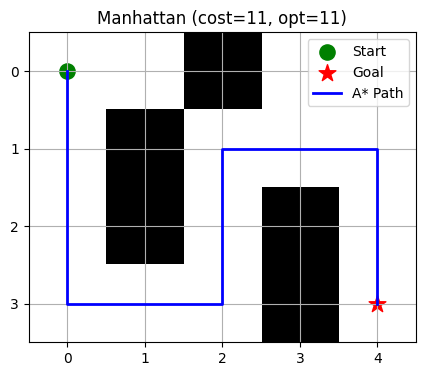


==== Running Test ====
Maze size: 3 x 4
Heuristic: Manhattan
Found cost: 5 | Optimal cost: 5
Optimal? YES
Nodes expanded: 12


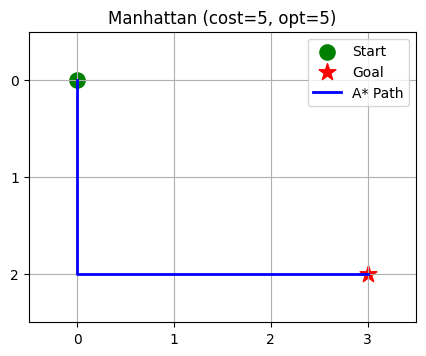


==== Running Test ====
Maze size: 4 x 5
Heuristic: 1.5 * Manhattan
Found cost: 11 | Optimal cost: 11
Optimal? YES
Nodes expanded: 13


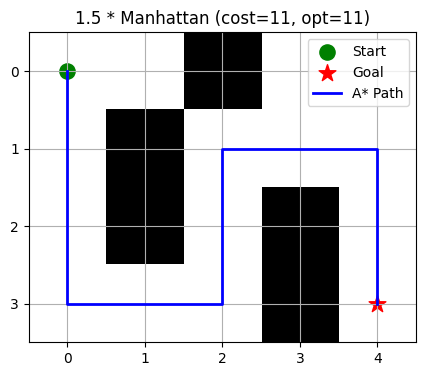


==== Running Test ====
Maze size: 3 x 4
Heuristic: 1.5 * Manhattan
Found cost: 5 | Optimal cost: 5
Optimal? YES
Nodes expanded: 6


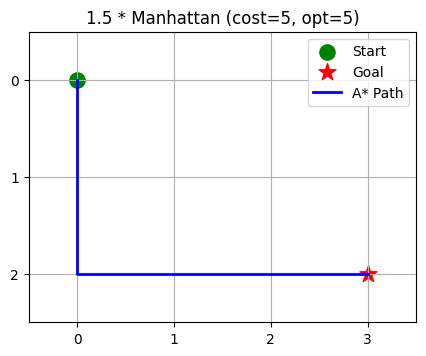


==== Running Test ====
Maze size: 4 x 5
Heuristic: Inconsistent (special=(0,1))
Found cost: 11 | Optimal cost: 11
Optimal? YES
Nodes expanded: 13


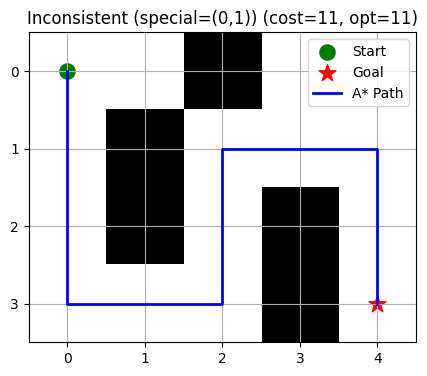

In [3]:
# Example Mazes 

maze1 = Maze(
    grid=[
        [0,0,1,0,0],
        [0,1,0,0,0],
        [0,1,0,1,0],
        [0,0,0,1,0]
    ],
    start=(0,0),
    goal=(3,4)
)

maze2 = Maze(
    grid=[
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0]
    ],
    start=(0,0),
    goal=(2,3)
)

# Runner Function

def run_test(maze: Maze, hfun, hname: str):
    """Run A* with given heuristic and compare with BFS optimal path"""
    opt_path, opt_cost = bfs_shortest_path(maze)
    path, cost, expanded = a_star_search(maze, lambda n: hfun(n, maze.goal) if hfun.__code__.co_argcount==2 else hfun(n))

    print("\n==== Running Test ====")
    print("Maze size:", len(maze.grid), "x", len(maze.grid[0]))
    print("Heuristic:", hname)
    print("Found cost:", cost, "| Optimal cost:", opt_cost)
    print("Optimal?", "YES" if abs(cost-opt_cost) < 1e-9 else "NO")
    print("Nodes expanded:", len(expanded))

    show_path(maze, path, f"{hname} (cost={cost}, opt={opt_cost})")

# Run Cases 

# Case 1: Admissible Manhattan
run_test(maze1, manhattan_distance, "Manhattan")
run_test(maze2, manhattan_distance, "Manhattan")

# Case 2: Overestimating heuristic (non-admissible)
run_test(maze1, stretched_manhattan, "1.5 * Manhattan")
run_test(maze2, stretched_manhattan, "1.5 * Manhattan")

# Case 3: Inconsistent heuristic (special cell)
h_inconsistent = quirky_heuristic(maze1.goal, (0,1))
run_test(maze1, h_inconsistent, "Inconsistent (special=(0,1))")
